## T1 Fitting
The t1_fit module contains classes for estimating T1. Both these and the classes in dce_fit are subclasses of Fitter, which means they can be used to fit a single T1 value (using the proc method) or an entire image (using the proc_image method).

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../src')
import t1_fit
%load_ext autoreload
%autoreload 2

## T1 estimation methods (one value)
The variable flip angle method estimates T1, using the relationship between flip angle, T1 and SPGR signal:

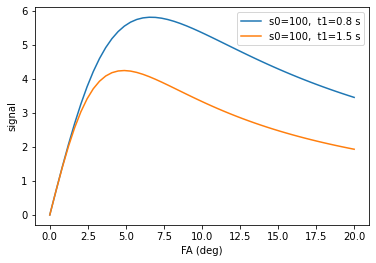

In [18]:
fa_range = np.linspace(0, 20, 50)
s_range_1 = t1_fit.spgr_signal(s0=100,  t1=0.8, tr=5.4e-3, fa=fa_range)
s_range_2 = t1_fit.spgr_signal(s0=100,  t1=1.5, tr=5.4e-3, fa=fa_range)
plt.plot(fa_range, s_range_1, '-', label='s0=100,  t1=0.8 s')
plt.plot(fa_range, s_range_2, '-', label='s0=100,  t1=1.5 s')
plt.xlabel('FA (deg)')
plt.ylabel('signal');
plt.legend();

#### Variable flip angle mapping (2 x flip angles)
The simplest approach is to estimate T1 from two SPGR acquisitions with different flip angles. This is fastest but least precise method:

Wall time: 0 ns
Fitted values: s0 = 13600.3, t1 = 1.326 s


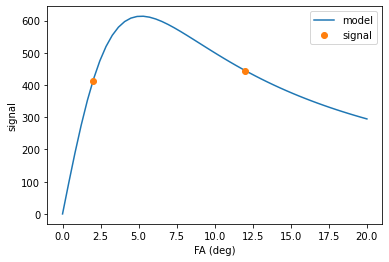

In [19]:
# Fit data:
s = np.array([413, 445])
tr = 5.4e-3
fa = np.array([2, 12])
%time s0, t1 = t1_fit.VFA2Points(fa, tr).proc(s)

# Plot data:
print(f"Fitted values: s0 = {s0:.1f}, t1 = {t1:.3f} s")
plt.plot(fa_range, t1_fit.spgr_signal(s0=s0,  t1=t1, tr=tr, fa=fa_range), '-', label='model')
plt.plot(fa, s, 'o', label='signal')
plt.xlabel('FA (deg)')
plt.ylabel('signal');
plt.legend();

#### Variable flip angle (based on 3 x flip angles)
Fit multiple acquisitions using the **linear regression** method (moderately fast, moderately accurate):

Wall time: 959 µs
Fitted values: s0 = 13531.9, t1 = 1.326 s


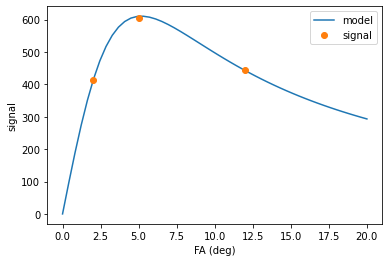

In [20]:
# Fit data:
s = np.array([413, 604, 445])
tr = 5.4e-3
fa = np.array([2, 5, 12])
%time s0, t1 = t1_fit.VFALinear(fa, tr).proc(s)

# Plot data:
print(f"Fitted values: s0 = {s0:.1f}, t1 = {t1:.3f} s")
plt.plot(fa_range, t1_fit.spgr_signal(s0=s0,  t1=t1, tr=tr, fa=fa_range), '-', label='model')
plt.plot(fa, s, 'o', label='signal')
plt.xlabel('FA (deg)')
plt.ylabel('signal');
plt.legend();

Now fit using the **non-linear** method (slowest, most accurate):

Wall time: 1.99 ms
Fitted values: s0 = 13482.2, t1 = 1.323 s


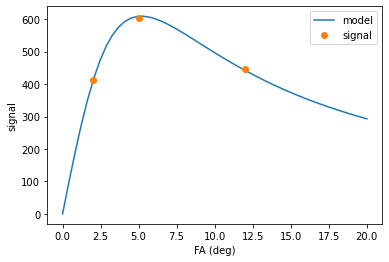

In [21]:
# Fit data:
s = np.array([413, 604, 445])
tr = 5.4e-3
fa = np.array([2, 5, 12])
%time s0, t1 = t1_fit.VFANonLinear(fa, tr).proc(s)

# Plot data:
print(f"Fitted values: s0 = {s0:.1f}, t1 = {t1:.3f} s")
plt.plot(fa_range, t1_fit.spgr_signal(s0=s0,  t1=t1, tr=tr, fa=fa_range), '-', label='model')
plt.plot(fa, s, 'o', label='signal')
plt.xlabel('FA (deg)')
plt.ylabel('signal');
plt.legend();

#### DESPOT1-HIFI method
T1 can be estimated using a combination of SPGR (FLASH) and IR-SPGR (MP-RAGE) acquisitions. This technique also estimates the relative flip angle k_fa (nominal/actual FA).  Now add 2 x IR-SPGR acquisitions to the previous 3 x SPGR scans. We now have 5 x acquisitions. All parameters are specified for each acquisition.

Wall time: 2.91 ms
Fitted values: s0 = 11856.2, t1 = 1.022 s, k_fa = 1.138


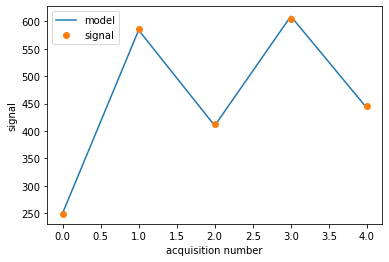

In [22]:
s = np.array([249, 585, 413, 604, 445]) # signal
esp = np.tile(5.4e-3, 5) # echo spacing (IR-SPGR) or TR (SPGR)
ti = np.array([0.1680, 1.0680, np.nan, np.nan, np.nan]) # delay after inversion pulse
n = np.array([160, 160, np.nan, np.nan, np.nan]) # number of readout pulses (IR-SPGR only)
b = np.array([5, 5, 2, 5, 12]) # excitation flip angle
td = np.array([0, 0, np.nan, np.nan, np.nan]) # delay between end of readout train and next inversion pulse (IR-SPGR only)
centre = np.array([0.5, 0.5, np.nan, np.nan, np.nan]) # time when centre of k-space is acquired (expressed as fraction of readout pulse train length; IR-SPGR only)

t1_calculator = t1_fit.HIFI(esp, ti, n, b, td, centre)
%time s0, t1, k_fa, s_fit = t1_calculator.proc(s)
s0, t1, k_fa, s_fit = t1_calculator.proc(s)

# Plot data:
print(f"Fitted values: s0 = {s0:.1f}, t1 = {t1:.3f} s, k_fa = {k_fa:.3f}")
plt.plot(np.arange(5), s_fit, '-', label='model')
plt.plot(np.arange(5), s, 'o', label='signal')
plt.xlabel('acquisition number')
plt.ylabel('signal');
plt.legend();

### Reference values
Obtained from fitting DESPOT1-HIFI signal in Matlab:
T1 = 1.0218
s0 = 11856
k = 1.1379
(data from: INV_ED_004, FSLEyes coordinates 98,99,106)

---
## T1 mapping
We use the same approach to perform voxelwise fitting and generate a T1 map.  
The demo data was obtained on a 3-T Siemens Prisma scanner and includes 2 x IR-SPGR and 3 x SPGR scans.
The IR sequence uses a linear readout for the pulse train and all partitions in k-space are acquired in a single shot.  
Note, the TI specified at the scanner console (and reported in the dicom header) must be converted to the actual TI delay, i.e. that between inversion and the start of the SPGR pulse train:  
$TI_{delay} = TI_{eff} - 0.5 N_{slices} ESP$,  where ESP is the echo spacing.  

### Variable flip angle
First, fit the 3 x SPGR scans, i.e. variable flip angle method.  
Start by creating a fitting object, specifying the sequence parameters:

In [20]:
vfa_fitter = t1_fit.VFALinear(fa=[2, 5, 12], tr=5.4e-3)

Now use the proc_image method to fit every voxel and generate output images:

In [22]:
images = [os.path.join('.', 'T1_data', img) for img in ['FA2.nii.gz', 'FA5.nii.gz', 'FA12.nii.gz']]

s0, t1 = vfa_fitter.proc_image(images, threshold=50, dir='C:\\temp\\sepal', suffix='_VFA');

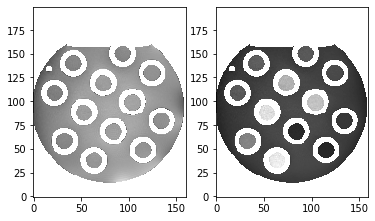

In [24]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(s0[78,:,:], cmap="gray", origin="lower", vmin=0, vmax=3000)
ax[1].imshow(t1[78,:,:], cmap="gray", origin="lower", vmin=0, vmax=2);

### DESPOT1-HIFI
Now fit all 5 scans using the DESPOT1-HIFI method.

In [25]:
hifi_fitter = t1_fit.HIFI(esp = np.array([5.4e-3, 5.4e-3, 5.4e-3, 5.4e-3, 5.4e-3]),
                          ti = np.array([168e-3, 1068e-3, np.nan, np.nan, np.nan]),
                          n = np.array([160, 160, np.nan, np.nan, np.nan]),
                          b = np.array([5, 5, 2, 5, 12]),
                          td = np.array([0, 0, np.nan, np.nan, np.nan]),
                          centre = np.array([0.5, 0.5, np.nan, np.nan, np.nan]))

To save time, use multple cores and supply a mask image to process a subset of voxels:

In [26]:
images = [os.path.join('.', 'T1_data', img) for img in ['TI_168ms.nii.gz', 'TI_1068ms.nii.gz', 'FA2.nii.gz', 'FA5.nii.gz', 'FA12.nii.gz']]

s0, t1, k_fa, s_fit = hifi_fitter.proc_image(images, 
                                             mask='.\\T1_data\\mask.nii.gz',
                                             threshold=50,
                                             dir='C:\\temp\\sepal',
                                             suffix='_HIFI',
                                             n_procs=4);

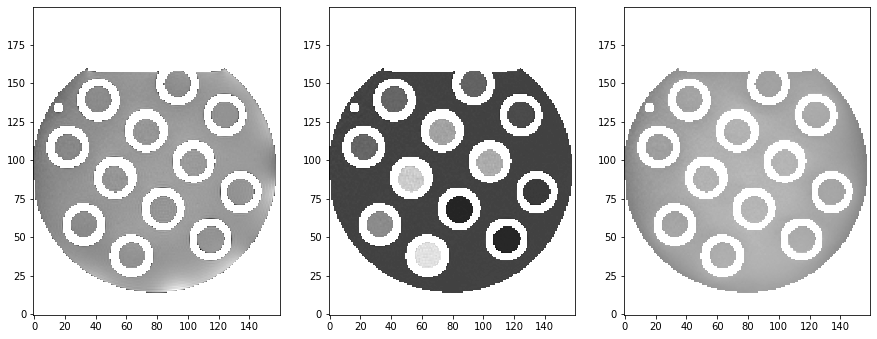

In [45]:
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(s0[78,:,:], cmap="gray", origin="lower", vmin=0, vmax=3000)
ax[1].imshow(t1[78,:,:], cmap="gray", origin="lower", vmin=0, vmax=2)
ax[2].imshow(k_fa[78,:,:], cmap="gray", origin="lower", vmin=0, vmax=1.5);